In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import (RandomForestClassifier, 
                                      DecisionTreeClassifier)


In [2]:
spark = SparkSession.builder.appName("Feature_Selection_Logit").getOrCreate()

In [16]:
#df_feat_targ = spark.read.csv('dataFrame target and features(fuga).csv/', header = True, inferSchema = True)
#df_feat_targ = spark.read.csv('dataFrame target and features(fuga 3 meses antes).csv/', header = True, inferSchema = True)
df_feat_targ = spark.read.csv('dataFrame target and features(fuga 3 meses antes no-current).csv/', header = True, inferSchema = True)



In [133]:
df_feat_targ.count()

6897273

### Feature Selection 1: 

In [17]:
N_fugas = df_feat_targ.filter("estado = 1").count()

In [18]:
N_fugas

38146

In [6]:
def FeatureSelection(df_spark, N_0, test_size, features_columns):

        
    df_fts_select1 = df_spark.filter("estado = 1").union(df_spark.filter("estado = 0").limit(N_0))
    df_fts_targ_pd = df_fts_select1.toPandas()

    train_data, test_data = train_test_split(df_fts_targ_pd, test_size = test_size, random_state = 1)

    y_train  = train_data[['estado']]
    y_test = test_data[['estado']]
    x_train1 = train_data[features_columns]
    x_test1 = test_data[features_columns]
    
    return x_train1, x_test1, y_train, y_test


def FeatureSelectionPyspark(df_spark, N_0, test_size, features_columns):
    
    df_fts_select1 = df_spark.filter("estado = 1").union(df_spark.filter("estado = 0").limit(N_0))
   
    assembler = VectorAssembler(inputCols = features_columns, outputCol = 'features')  
    output = assembler.transform(df_fts_select1)
    
    final_df = output.select('features','estado')
    
    train_data, test_data = final_df.randomSplit([1-test_size, test_size])

    return train_data, test_data

#### Quité las columnas "deuda_directa_inversiones_financieras", "deuda_directa_ops_pacto" y "deuda_indirecta_comercial_ext" porque tienen sólo valores nulos.

### Regresion Logística

In [7]:
def RegresionLogistica(x_train1, x_test1, y_train, y_test):
    x_train = sm.add_constant(x_train1)
    x_test = sm.add_constant(x_test1)

    reg_log = sm.Logit(y_train,x_train)
    results_log = reg_log.fit()
    return results_log, x_test, y_test#.summary()

### Decision Tree

In [8]:
def DecisionTree(df_train):
    
    dtc = DecisionTreeClassifier(labelCol = 'estado')
    dtc_model = dtc.fit(df_train)
    return dtc_model

### Random Forest

In [27]:
def RandomForest(df_train, N_trees):
    
    rfc = RandomForestClassifier(labelCol = 'estado', numTrees = N_trees)
    rfc_model = rfc.fit(df_train)
    return rfc_model

#### P-values: útiles para conocer qué variables tienen importancia estadística. Si p < 0.05, la variable es importante para el modelo.

### Matriz de Confusión

In [20]:
def CuentaActualPred(data, actual_values, model, threshold = 0.5):
    
        
        actual_values['predict'] = list(model.predict(data))
        
        actual1_pred1 = actual_values[(actual_values['estado'] == 1) \
                                      & (actual_values['predict'] > threshold)].shape[0]
        actual0_pred0 = actual_values[(actual_values['estado'] == 0)\
                                      & (actual_values['predict'] < threshold)].shape[0] 
        actual1_pred0 =  actual_values[(actual_values['estado'] == 1)\
                                      & (actual_values['predict'] < threshold)].shape[0]
        actual0_pred1 =  actual_values[(actual_values['estado'] == 0)\
                                      & (actual_values['predict'] > threshold)].shape[0]        
         

        return actual1_pred1, actual0_pred0, actual1_pred0, actual0_pred1

def CuentaActualPredPyspark(test_results):
    
    actual1_pred1 = test_results.filter((test_results['estado']==test_results['prediction']) & (test_results['estado']==1)).count()
    actual0_pred0 = test_results.filter((test_results['estado']==test_results['prediction']) & (test_results['estado']==0)).count()
    actual1_pred0 = test_results.filter((test_results['estado']!=test_results['prediction']) & (test_results['estado']==1)).count()
    actual0_pred1 = test_results.filter((test_results['estado']!=test_results['prediction']) & (test_results['estado']==0)).count()

    return actual1_pred1, actual0_pred0, actual1_pred0, actual0_pred1

def GenerarConfusionMatrix(actual1_pred1, actual0_pred0, actual1_pred0, actual0_pred1):
    
        cm_df = pd.DataFrame([[actual0_pred0, actual0_pred1], [actual1_pred0, actual1_pred1]])
        cm_df.columns = ['Predicted 0:', 'Predicted 1:']
        cm_df = cm_df.rename(index = {0: 'Actual 0:', 1: 'Actual 1'})
        accuracy = (actual0_pred0+actual1_pred1)/cm_df.sum().sum()
        
        
        print(cm_df, "\n")
        print("Accuracy: {} %".format(accuracy * 100), '\n')
        return actual0_pred0/(actual0_pred0+actual0_pred1), actual1_pred1/(actual1_pred1+actual1_pred0) #pred_values


# Testeo

### Regresión Logísitca

In [22]:
Features_columns = ['deuda_vigente', 'deuda_directa_morosa90',
           'deuda_directa_vencida', 'deuda_directa_mora180',
           'deuda_indirecta_mora180', 'deuda_indirecta_vigente',
           'deuda_indirecta_vencida', 'deuda_directa_comercial',
           'deuda_directa_cred_consumo', 'deuda_directa_hipotecaria',
           'deuda_directa_comercial_ext', 'deuda_directa_leasing', 'deuda_morosa_leasing',
           'monto_lineas_cred_disp']

# Features_columns = [ 
#            'deuda_directa_vencida', 'deuda_directa_mora180', 'deuda_indirecta_vigente',
#            'deuda_directa_cred_consumo',
#            'monto_lineas_cred_disp']

x_train1, x_test1, y_train, y_test = FeatureSelection(df_feat_targ, N_fugas, 0.2, Features_columns)

results, x_test, y_test = RegresionLogistica(x_train1, x_test1, y_train, y_test)

actual1_pred1, actual0_pred0, actual1_pred0, actual0_pred1 = CuentaActualPred(x_test,y_test,results)

aciertos_0, aciertos_1 = GenerarConfusionMatrix(actual1_pred1, actual0_pred0, actual1_pred0, actual0_pred1)

print("No se fuga: ",aciertos_0,"% aciertos." )
print("Se fuga: ",aciertos_1,"% aciertos,")

         Current function value: 0.677503
         Iterations: 35
           Predicted 0:  Predicted 1:
Actual 0:          3365          4270
Actual 1           1674          5950 

Accuracy: 61.04594010092404 % 

No se fuga:  0.4407334643091028 % aciertos.
Se fuga:  0.7804302203567681 % aciertos,


/home/dran/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


#### Ventana 1 mes (fuga real); 56.89 % acc
#### Ventana 3 meses teniendo en cuenta el mes de fuga real: 56.83 % acc
#### Ventana 3 meses SIN tener en cuenta el mes de fuga real: 61.05 % acc



In [140]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 estado   No. Observations:                98897
Model:                          Logit   Df Residuals:                    98891
Method:                           MLE   Df Model:                            5
Date:                Fri, 25 Oct 2019   Pseudo R-squ.:                 0.01279
Time:                        15:58:46   Log-Likelihood:                -67673.
converged:                       True   LL-Null:                       -68550.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0908      0.007     12.246      0.000       0.076       0.105
deuda_directa_vencida          0.0003   1.83e-05     15.105      0.000       0.000       0.000
deuda_directa_mora180       2.641e-05   2.47e-06     10.703      0.000    2.16e-05    3.12e-05
deuda_indirecta_vigente     1.515e-06    2.3e-07      6.582      0.000    1.06e-06    1.97e-06
deuda_directa_cred_consumo -1.301e-05   7.45e-07    -17.468      0.000   -1.45e-05   -1.15e-05
monto_lineas_cred_disp     -1.439e-05   7.17e-07    -20.062      0.000   -1.58e-05    -1.3e-05
==============================================================================================
"""

### Decision Tree

In [25]:
Features_columns = ['deuda_vigente', 'deuda_directa_morosa90',
           'deuda_directa_vencida', 'deuda_directa_mora180',
           'deuda_indirecta_mora180', 'deuda_indirecta_vigente',
           'deuda_indirecta_vencida', 'deuda_directa_comercial',
           'deuda_directa_cred_consumo', 'deuda_directa_hipotecaria',
           'deuda_directa_comercial_ext', 'deuda_directa_leasing', 'deuda_morosa_leasing',
           'monto_lineas_cred_disp']

# Features_columns = [ 
#            'deuda_directa_vencida', 'deuda_directa_mora180', 'deuda_indirecta_vigente',
#            'deuda_directa_cred_consumo',
#            'monto_lineas_cred_disp']

train_df, test_df = FeatureSelectionPyspark(df_feat_targ, N_fugas, 0.2, Features_columns)
dtc_model = DecisionTree(train_df)
test_results = dtc_model.transform(test_df).select(['estado','prediction'])

actual1_pred1, actual0_pred0, actual1_pred0, actual0_pred1 = CuentaActualPredPyspark(test_results)

aciertos_0, aciertos_1 = GenerarConfusionMatrix(actual1_pred1, actual0_pred0, actual1_pred0, actual0_pred1)

print("No se fuga: ",aciertos_0,"% aciertos." )
print("Se fuga: ",aciertos_1,"% aciertos,")

           Predicted 0:  Predicted 1:
Actual 0:          6783           811
Actual 1           2682          4922 

Accuracy: 77.0167127253586 % 

No se fuga:  0.8932051619699763 % aciertos.
Se fuga:  0.6472908995265649 % aciertos,


#### Ventana 1 mes (fuga real);  65.9% acc
#### Ventana 3 meses teniendo en cuenta el mes de fuga real: 71.6 % acc
#### Ventana 3 meses SIN tener en cuenta el mes de fuga real: 77.02 % acc


### Random Forest

In [73]:
import numpy as np
import matplotlib.pyplot as plt

def PlotAccuracy(train, test):

    trees = np.linspace(1,200,20)
    accu = []

    for n in trees:

        rfc_model = RandomForest(train, int(n))
        test_results = rfc_model.transform(test).select(['estado','prediction'])

        actual1_pred1, actual0_pred0, actual1_pred0, actual0_pred1 = CuentaActualPredPyspark(test_results)
        accu.append( (actual1_pred1 + actual0_pred0)/( actual1_pred1 + actual0_pred0 + actual1_pred0 + actual0_pred1 ) )

    plt.figure(1)
    plt.plot(trees, accu,'o--b')
    plt.xlabel("N° trees")
    plt.ylabel("% Accuracy")
    plt.grid()
    plt.ylim(0.6, 1)
    

In [59]:
Features_columns = ['deuda_vigente', 'deuda_directa_morosa90',
           'deuda_directa_vencida', 'deuda_directa_mora180',
           'deuda_indirecta_mora180', 'deuda_indirecta_vigente',
           'deuda_indirecta_vencida', 'deuda_directa_comercial',
           'deuda_directa_cred_consumo', 'deuda_directa_hipotecaria',
           'deuda_directa_comercial_ext', 'deuda_directa_leasing', 'deuda_morosa_leasing',
           'monto_lineas_cred_disp']

# Features_columns = [ 
#            'deuda_directa_vencida', 'deuda_directa_mora180', 'deuda_indirecta_vigente',
#            'deuda_directa_cred_consumo',
#            'monto_lineas_cred_disp']

train_df, test_df = FeatureSelectionPyspark(df_feat_targ, N_fugas, 0.2, Features_columns)
rfc_model = RandomForest(train_df, 1)
test_results = rfc_model.transform(test_df).select(['estado','prediction'])

actual1_pred1, actual0_pred0, actual1_pred0, actual0_pred1 = CuentaActualPredPyspark(test_results)

aciertos_0, aciertos_1 = GenerarConfusionMatrix(actual1_pred1, actual0_pred0, actual1_pred0, actual0_pred1)

print("No se fuga: ",aciertos_0,"% aciertos." )
print("Se fuga: ",aciertos_1,"% aciertos,")

           Predicted 0:  Predicted 1:
Actual 0:          6746           872
Actual 1           2677          4975 

Accuracy: 76.75834970530452 % 

No se fuga:  0.8855342609608822 % aciertos.
Se fuga:  0.6501568217459488 % aciertos,


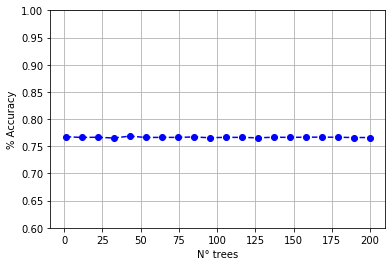

In [74]:
PlotAccuracy(train_df, test_df)

## ------------------------------------------------------------------------------------------------

## ------------------------------------------------------------------------------------------------